## **<h3 align="center"> Text Mining - Project </h3>**
# **<h3 align="center">Genre Classification</h3>**
**Group members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Ilona Nacu - 20211602@novaims.unl.pt - 20211602<br>
Francisco Farinha - 20211550@novaims.unl.pt - 20211550<br>
João Barradas - 20211590@novaims.unl.pt - 20211590<br>
Rafael Proença  - 2021681@novaims.unl.pt - 2021681<br>

# Introduction
This notebook focuses on using text mining techniques to classify song lyrics into different genres. We'll explore various machine learning models to analyze the textual content of songs, aiming to accurately categorize them into specific music genres. The notebook is organized into sections covering model implementations, performance evaluations, and fine-tuning techniques, leading to the selection of a final model for genre classification based solely on lyrical content.
The explored models and techniques are the ones taught in class.

We experimented with several approaches in our project:

**Vectorization Techniques Employed:**
- TF-IDF

**Models Explored:**
- One vs Rest using Logistic Regression
- Softmax
- Multinomial Naive Bayes

**Techniques Applied:**
- Stratified k-fold
- Grid Search


## Table of Contents
* [1. Import Packages and Data](#chapter1)
* [2. Preparing Data to Model](#chapter2)
* [3. Vectorization Method: TF-IDF](#chapter3)
* [4. Multiclass Classification Models](#chapter4)
    * [4.1. OvsRest Classifier](#section_4_1)
        * [4.1.1. Modeling](#sub_section_4_1_1)    
        * [4.1.2. Check Performance](#sub_section_4_1_2)    
    * [4.2. Softmax Regression (or Multinomial Logistic Regression) ](#section_4_2)
        * [4.2.1. Modeling](#sub_section_4_2_1) 
        * [4.2.2. Checking Performance](#sub_section_4_2_2) 
    * [4.3. Multinomial Naive Bayes](#section_4_3)
        * [4.3.1. Modeling](#sub_section_4_3_1) 
        * [4.3.2. Check Performance](#sub_section_4_3_2) 
* [5. Stratified K-Fold](#chapter5)
    * [5.1. OvsR - With Stopwords and Lemmatization](#section_5_1) 
    * [5.2. OvsR - With Removed Stopwords and No Lemmatization](#section_5_2)        
    * [5.3. Softmax - With Stopwords and No Lemmatization](#section_5_3) 
* [6. Grid Search](#chapter6)
    * [6.1. Modeling](#section_6_1) 
    * [6.2. Best Model](#section_6_2) 
    * [6.3. Improved Stratified K-Folds](#section_6_3) 
* [7. Final Model](#chapter7)

## 1. Import packages and data <a class="anchor" id="chapter1"></a> 
---
In the upcoming code segment, we'll include the essential imports necessary for Genre Classification.

In [1]:
#pandas and numpy for df manipulation
import pandas as pd
import numpy as np
import re
import nltk
import statistics
import random

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

#From utils
from utils import plot_confusion_matrix, stratified_kfold_crossval

# 2. Preparing data to model <a class="anchor" id="chapter2"></a>

Loading the preprocessed dataset, which is a result from running Notebook 1.

In [2]:
songs = pd.read_csv('processed_songs_eng.csv')
songs.set_index('id', inplace = True)

In [3]:
songs  #Confirming everything was loaded correctly

,title,tag,artist,year,views,features,lyrics,Lyrics_Length,Has_regex,lyrics_without_regex,preproc_content,lyrics_rst_nolem,lyrics_norst_lemm,lyrics_norstnolemm,preproc_content_without_wc
id,,,,,,,,,,,,,,,
535805,Walk Away,rock,Tony Molina,2013,699,{},When you said you loved me\nDid you mean it th...,193,0,When you said you loved me Did you mean it the...,say love mean change mind one day pretend caus...,said loved mean change mind day pretend cause...,when you you me do you mean it then do you c...,when you said you loved me did you mean it the...,mean change mind day pretend cause walk aw...
7519483,Gotta Make It Kid Naruto Rap,rap,Reece Lett,2021,4,{Sl!ck},Kid Naruto Rap\n[Hook]\nEverybody wants you to...,2143,0,Kid Naruto Rap Everybody wants you to hurt E...,kid naruto rap everybody want hurt everybody w...,kid naruto rap everybody wants hurt everybody ...,kid naruto rap everybody you to hurt everybod...,kid naruto rap everybody wants you to hurt eve...,kid naruto rap everybody hurt everybody cry ...
4892808,​this is what i asked for,pop,Elliot (DNK),2019,389,{},[Verse 1]\nPeople tell me I've changed\nI find...,644,1,People tell me I ve changed I find it hard t...,people tell change find hard explain maybe fee...,people tell changed find hard explain maybe ...,people tell me i ve change i find it hard to e...,people tell me i ve changed i find it hard to ...,people tell change find hard explain maybe ...
1584150,Stealing Hearts,pop,Katie Armiger,2013,126,{},You've been warned about me\nDon't try to get ...,1387,0,You ve been warned about me Don t try to get t...,warn try get close know want chain leave ghost...,warned try close chain leave ghost took 69 ...,you ve be warn about me don try to too close ...,you ve been warned about me don try to too cl...,warn try close chain leave ghost 69 cadill...
7639050,Get Ready,country,John Campbell Munro,1,2,{},[Verse 1]\nI can see the end is coming but I’v...,1090,1,I can see the end is coming but Ive never li...,see end come ive never like odds need way even...,end coming ive liked odds need even deal fi...,i can the end be but ive the odds i need a...,i can the end is coming but ive liked the od...,end ive odds need even deal field around ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702980,Manhattan,pop,Tijuana Sweetheart,2007,48,{},If I knew when I was young that I'd be older\n...,1460,0,If I knew when I was young that I d be older T...,know young old many thing would tell chance te...,knew young older many things would told chance...,if i when i be young that i be old there be s...,if i knew when i was young that i be older the...,young old many thing would tell chance tell s...
4802970,Belly Shit,rap,Lil Gotit,2019,3593,"{""Lil Troup""}",[Intro: Lil Gotit]\nCash\nWah-wah-wah\nWah-wah...,4247,1,Cash Wah-wah-wah Wah-wah-wah Everything is c...,cash wah-wah-wah wah-wah-wah everything chrome...,cash wah-wah-wah wah-wah-wah everything chrome...,cash wah-wah-wah wah-wah-wah everything be chr...,cash wah-wah-wah wah-wah-wah everything is chr...,cash wah-wah-wah wah-wah-wah everything chrome...
403929,The Four Loves,rock,Heath McNease,2014,301,{},[Verse 1]\nI was born inside a home\nThe young...,1091,1,I was born inside a home The youngest of the...,bear inside home young three boy fight daddy s...,born inside home youngest three boys fought da...,i be bear inside a home the young of the three...,i was born inside a home the youngest of the t...,bear inside home young three boy fight daddy s...


In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134789 entries, 535805 to 6177674
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   title                       134787 non-null  object
 1   tag                         134789 non-null  object
 2   artist                      134789 non-null  object
 3   year                        134789 non-null  int64 
 4   views                       134789 non-null  int64 
 5   features                    134789 non-null  object
 6   lyrics                      134789 non-null  object
 7   Lyrics_Length               134789 non-null  int64 
 8   Has_regex                   134789 non-null  int64 
 9   lyrics_without_regex        134789 non-null  object
 10  preproc_content             134789 non-null  object
 11  lyrics_rst_nolem            134789 non-null  object
 12  lyrics_norst_lemm           134789 non-null  object
 13  lyrics_norstnolemm          

Before moving on to the necessary approaches for Genre Classification, we'll need to encode our target.

In [4]:
# Create a train-test split for testing the classifier
X_train, X_test, y_train, y_test = train_test_split(
    songs["preproc_content_without_wc"], songs["tag"], test_size=0.2, random_state=38)

#Extracting the indexes
train_index = list(X_train.index)
test_index = list(X_test.index)

# 3. Vectorization Method: TF-IDF <a class="anchor" id="chapter3"></a>
---------------

#### TF - IDF

>TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used in natural language processing and information retrieval to gauge the importance of a word in a document relative to a collection of documents. It measures how frequently a term appears in a document and how often it appears overall, emphasizing terms that are frequent in a document but relatively rare across the corpus. This way, it highlights words that are both important within a document and distinctive in the entire collection. Helps in representing the significance of words in a document by considering both the local importance and the global rarity. <br>
An alternative to TF-IDF is Bag of Words, which represents data by counting the frequency of words in a document, and we tried using it, but it took too long and, for our specific case, we believe TF-IDF is more useful, especially since it's not just a simple frequency of the words, it also takes into account how rare they are overall. Because of that, we did not feel the need to keep the code, since it did not provide any interesting insights besides this conclusion.

In the following cells, we will initialize variables with Tf-IDF.

In [3]:
#Initiating the encoder that will be used for our target
encoder = LabelEncoder()

In [6]:
# Vectorizing the lyrics for the training and testing splits
corpus = songs["preproc_content_without_wc"].loc[train_index]
tfidf_vectorizer = TfidfVectorizer()
tfidf_model = tfidf_vectorizer.fit(corpus)

X_train = tfidf_vectorizer.transform(songs["preproc_content_without_wc"].loc[train_index])
X_test = tfidf_vectorizer.transform(songs["preproc_content_without_wc"].loc[test_index])

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

#Encoding the target
encoder.fit(songs[['tag']])

y_train = encoder.transform(songs[["tag"]].loc[train_index])
y_test = encoder.transform(songs[["tag"]].loc[test_index])

C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# 4.  Multiclass Classification Models <a class="anchor" id="chapter4"></a>
---
Our lyric genre classification problem can also be called a multiclass classification, as we only want to obtain one class per lyric, using the text as model input, as opposed to a multilabel problem, where more than one class can be assigned to each line.<br>
<br>
As mentioned before we will try to use One vs Rest with Logistic Regression, Softmax and Multinomial Naive Bayes.

- For some models, we attemped to solve our class imbalance by using manually defined class weights. We used the values from the balanced weights, and changed as was needed for certain classes. The ones bellow are the ones that provided the best results with our attempted models.

In [21]:
class_weights = compute_class_weight('balanced', classes= np.unique(y_train), y= y_train)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 6.4974090142202945,
 1: 4.001744229199139,
 2: 0.4050994800589066,
 3: 0.5808795802493077,
 4: 3.6336096508963474,
 5: 0.8842230422304223}

In [22]:
manual_weights = {
    0: 8,  
    1: 4,  
    2: 0.6,   
    3: 0.6,
    4: 20,
    5: 0.88
}

# Define the manual weights
class_weights = [manual_weights[i] for i in np.unique(y_train)]
class_weights_dict = dict(enumerate(class_weights))

## 4.1. OvsR Classifier <a class="anchor" id="section_4_1"></a>

 **One Vs Rest with Logistic Regression**

>The One vs Rest method treats each class as a binary classification task against all other classes combined, reducing a multiclass problem into numerous binary classification tasks, which is where logistic regression can come in. <br>
Logistic regression, similar to linear regression, scales input variables linearly and is a statistical method used for binary classification, where the goal is to predict the probability that an instance belongs to a particular class, using a sigmoid function. By using one vs rest method combined with logistic regression, we are able to handle multiclass problems.

### 4.1.1. Modeling <a class="anchor" id="sub_section_4_1_1"></a>

Hyperparameters used:
- **solver:** specifies the optimization algorithm to use in the logistic regression model. In this case, `'liblinear'` is chosen, which is suitable for small to medium-sized datasets, but it worked well with this dataset.
- **random_state:** specifying the seed value for the random number generator, so that the results can be obtained again.
- **class_weight:** This parameter assigns weights to classes to handle class imbalance. `class_weights_dict`  cwas defined above.
- **max_iter:** maximum number of iterations taken for the solver to converge. The default value was too small and we always got a warning, so we increased it.
- **C:** It's the inverse of regularization strength in logistic regression. A smaller `C` value indicates stronger regularization, while a larger value implies weaker regularization. Here, `C=0.3` means a moderate level of regularization is applied, which was necessary as the model started to overfit after applying class weights.
- **penalty:** This parameter specifies the norm used in the penalization (regularization term) of the logistic regression model. `'l1'` penalty refers to L1 regularization, which reduces the coefficients of less important features to zero. L2, the other option, reduces the coefficients to something close to zero.

In [10]:
# Train the One-vs-Rest classifier using Logistic regression as the base estimator
ovr_model = OneVsRestClassifier(LogisticRegression(solver='liblinear', 
                                                   random_state=0, 
                                                   class_weight = class_weights_dict, 
                                                   max_iter=10000,
                                                   C =0.3, 
                                                   penalty = 'l1'))

#decreasing C while using class weights helped with overfitting
ovr_model.fit(X_train, y_train) 

ovr_model.multilabel_  #Confirming that the model is dealing with the data as a multiclass problem

False

### 4.1.2. Check performance <a class="anchor" id="sub_section_4_1_2"></a>


In [11]:
y_pred_ovr_train = ovr_model.predict(X_train)
print(classification_report(y_train, y_pred_ovr_train,  digits = 3))  

              precision    recall  f1-score   support

           0      0.708     0.111     0.192      2766
           1      0.869     0.485     0.623      4491
           2      0.617     0.883     0.727     44364
           3      0.855     0.863     0.859     30939
           4      0.645     0.065     0.118      4946
           5      0.644     0.308     0.417     20325

    accuracy                          0.695    107831
   macro avg      0.723     0.453     0.489    107831
weighted avg      0.705     0.695     0.660    107831



In [12]:
# Predictions on the test set
y_pred_ovr = ovr_model.predict(X_test)   

print(classification_report(y_test, y_pred_ovr,  digits = 3))  

              precision    recall  f1-score   support

           0      0.470     0.067     0.118       697
           1      0.783     0.410     0.539      1145
           2      0.595     0.840     0.697     11266
           3      0.826     0.841     0.834      7627
           4      0.385     0.038     0.069      1248
           5      0.508     0.252     0.337      4975

    accuracy                          0.656     26958
   macro avg      0.595     0.408     0.432     26958
weighted avg      0.639     0.656     0.618     26958



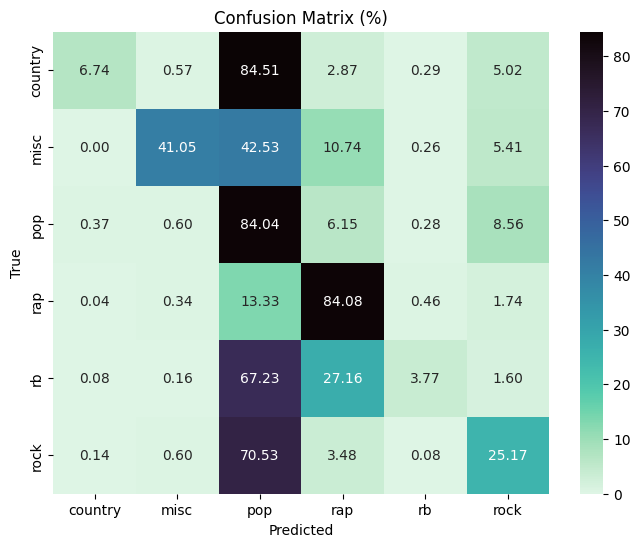

In [13]:
#Putting the data in the correct format for the confusion matrix funcition
y_pred_decoded_ovr = encoder.inverse_transform(y_pred_ovr)
y_test_decoded = encoder.inverse_transform(y_test)

plot_confusion_matrix(y_test_decoded, y_pred_decoded_ovr)

>Altough it's score is not bad, we can see that it does not deal very well with the class imbalance problem, assigning a lot of lyrics as pop, which is the most common genre in the dataset. It's is also possible to see that the model overfits too, going from a 0.66 on the train data to 0.618 on the test.

This model's performance on the class Kaggle competion was: 0.6178

## 4.2. Softmax Regression (or Multinomial Logistic Regression) <a class="anchor" id="section_4_2"></a>

>Instead of using a sigmoid function on a Logistic Regression model, a softmax function is used, making it adequate for multiclass problems. A softmax regression's output is a probability estimate for each observation for each class.

### 4.2.1. Modeling <a class="anchor" id="sub_section_4_2_1"></a>

Hyperparameters used: 
- **solver:** `'lbfgs'` handles multinomial loss, making it suitable for the Softmax regression.
- **multi_class:** specifies the strategy used to handle multinomial loss funciton. `'multinomial'` is chosen because we want to use the Softmax function.


In [14]:
# Train the Softmax (Multinomial) regression classifier
softmax_model = LogisticRegression(solver='lbfgs', 
                                   random_state=0, 
                                   max_iter=10000, 
                                   C=0.8,
                                   multi_class='multinomial')
softmax_model.fit(X_train, y_train)

#Predictions on the test set
y_pred_softmax = softmax_model.predict(X_test)

### 4.2.2. Check Performance <a class="anchor" id="sub_section_4_2_2"></a>


In [15]:
#Checking performance on training data - so that we can check for overfitting

y_pred_soft_train = softmax_model.predict(X_train)
print(classification_report(y_train, y_pred_soft_train, digits = 3))  

              precision    recall  f1-score   support

           0      0.712     0.089     0.159      2766
           1      0.934     0.488     0.641      4491
           2      0.627     0.897     0.738     44364
           3      0.869     0.865     0.867     30939
           4      0.603     0.082     0.145      4946
           5      0.700     0.353     0.469     20325

    accuracy                          0.710    107831
   macro avg      0.741     0.462     0.503    107831
weighted avg      0.724     0.710     0.678    107831



In [16]:
print(classification_report(y_test, y_pred_softmax, digits = 3))  

              precision    recall  f1-score   support

           0      0.430     0.053     0.095       697
           1      0.865     0.386     0.534      1145
           2      0.592     0.847     0.697     11266
           3      0.839     0.832     0.835      7627
           4      0.410     0.054     0.096      1248
           5      0.515     0.261     0.346      4975

    accuracy                          0.658     26958
   macro avg      0.608     0.405     0.434     26958
weighted avg      0.647     0.658     0.621     26958



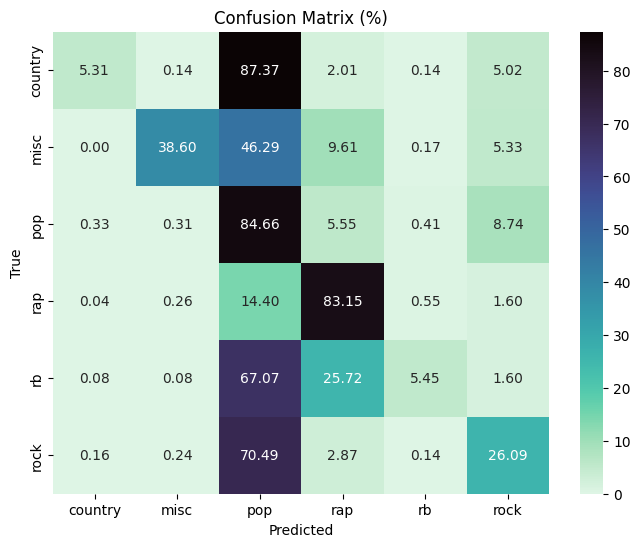

In [17]:
#Putting the data in the correct format for the confusion matrix funcition
y_pred_decoded_softmax = encoder.inverse_transform(y_pred_softmax)
y_test_decoded = encoder.inverse_transform(y_test)

plot_confusion_matrix(y_test_decoded, y_pred_decoded_softmax)

> The model also has overfitting, it presents the same issues as seen in 2.1.3, but the weighted f1 metric is a little higher for the test, as it has 0.621.

This model's performance on the class Kaggle competion was: 0.6225

## 4.3. Multinomial Naive Bayes <a class="anchor" id="section_4_3"></a>

>Multinomial Naive Bayes (MNB) is a probabilistic machine learning algorithm commonly used for classification tasks, particularly with text data. It's an extension of the Naive Bayes algorithm, designed to handle features representing counts or frequencies. MNB calculates probabilities based on the frequency of occurrences of features within each class.
MNB operates on the assumption of feature independence given the class. Despite this simplification (which might not hold in real-world scenarios), it tends to work. MNB estimates the probability of a sample belonging to a particular class given its features by combining prior probabilities and conditional probabilities of the features given the class using Bayes' theorem. The class with the highest probability is the one assigned as answer.

We introduce this algorithm just to compare with the ones above, which were explored in depth in our practical classes. <br>
An advantage that we found in this model is that it's the fastest to run, but sadly its results arent' very good.

### 4.3.1. Modeling <a class="anchor" id="sub_section_4_3_1"></a>

In [18]:
# Initialize the Multinomial Naive Bayes model
mnb = MultinomialNB()

# Create One-vs-Rest classifier with MNB as the base estimator
nb_model = OneVsRestClassifier(mnb)

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_nb = nb_model.predict(X_test)

### 4.3.2. Check performance <a class="anchor" id="section_4_3_2"></a>

In [19]:
#checking performance on training data - so that we can check for overfitting
y_pred_nb_train = nb_model.predict(X_train)
print(classification_report(y_train, y_pred_nb_train, digits = 3))  

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      2766
           1      0.974     0.059     0.111      4491
           2      0.558     0.919     0.695     44364
           3      0.778     0.850     0.813     30939
           4      1.000     0.000     0.000      4946
           5      0.923     0.034     0.066     20325

    accuracy                          0.631    107831
   macro avg      0.706     0.310     0.281    107831
weighted avg      0.713     0.631     0.536    107831



C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print(classification_report(y_test, y_pred_nb, digits = 3))  

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       697
           1      1.000     0.033     0.064      1145
           2      0.553     0.901     0.685     11266
           3      0.753     0.834     0.791      7627
           4      0.000     0.000     0.000      1248
           5      0.760     0.015     0.030      4975

    accuracy                          0.617     26958
   macro avg      0.511     0.297     0.262     26958
weighted avg      0.627     0.617     0.519     26958



C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>The weighted f1 is much lower than on the models from 2.1 and 2.2, and some classes aren't even being predicted. Since the results were so bad, we do not feel the need to submit these results to the class Kaggle competition. <br>
Comparing this model with the ones learned in class, we can see that this ones performs worse on our data.

# 5. Stratified K-Fold  <a class="anchor" id="chapter5"></a>


>It's an alternative to the simple hold-out method, appropriate when there is class imbalance, which is the case for this dataset. The stratified approach involves dividing the dataset into K folds while preserving the percentage of samples for each class in every fold. This ensures that each fold is a representative sample of the entire dataset in terms of class distribution. The model is trained and evaluated K times, with each fold used once as a validation set while the remaining folds constitute the training set. The performance metrics (such as accuracy, precision, recall, etc.) obtained from each fold are then averaged to estimate the overall performance of the model.

The attempts in this section are mostly with the other columns we have available. We did more attempts but nothing of interest, so we thought it best just to showcase the performance on lyrics with different preprocessing techniques than the ones from above, in terms of stopwords removal and lemmatization.

**Note:** Since we have the option of checking our performance on Kaggle, for this section, we decided not to use only a part of the data on the stratified k fold and then test it on unseen data. Our test for unseen data was done on the actual provided test set, and the values obtained thorough the Kaggle competition are at the end of each of the three present models. <br>
We will be using 6 folds, which seemed a good balance between computational complexity while still giving the model a good number of folds to give us good results. We tried more but the results were almost exactly the same, so using 6, since it's faster to run, seemed like the best choice.

## 5.1. OvsR - With Removed Stopwords and No Lemmatization <a class="anchor" id="section_5_1"></a>

Lyrics with removed stop words but no lemmatization.

In [21]:
stkf_ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', 
                                                  random_state=0, 
                                                  max_iter = 10000,
                                                 penalty = None))

#Calling a function defined by us, in utils
avg_accuracy, avg_precision, avg_recall, avg_f1, stkf_ovr, vectorizer_ovr_stkf = stratified_kfold_crossval(
                                                                            songs=songs,
                                                                            data = songs['lyrics_rst_nolem'], 
                                                                            classifier = stkf_ovr, num_folds = 6)

C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6


In [22]:
# Display average classification metrics
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.6565
Average Precision: 0.6478
Average Recall: 0.6565
Average F1 Score: 0.6131


>Our submission on Kaggle with this model resulted in a score of: 0.6218

## 5.2. OvsR - With Stopwords and Lemmatization <a class="anchor" id="section_5_2"></a>

Lyrics with lemmatization, but with the stop words not removed.

In [23]:
stkf_ovr_lib = OneVsRestClassifier(LogisticRegression(solver='liblinear', 
                                                      random_state=0,
                                                      max_iter=10000,  
                                                      C = 0.8))
#Calling a function defined by us, in utils
avg_accuracy, avg_precision, avg_recall, avg_f1, stkf_ovr_lib, vectorizer_ovr_lib = stratified_kfold_crossval(
                                                                                        songs=songs,
                                                                                        data = songs['lyrics_norst_lemm'], 
                                                                                        classifier = stkf_ovr_lib, 
                                                                                        num_folds = 6)


C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6


In [24]:
# Display average classification metrics
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.6604
Average Precision: 0.6525
Average Recall: 0.6604
Average F1 Score: 0.6156


>Our submission on Kaggle with this model resulted in a score of: 0.6255

## 5.3. Softmax - With Stopwords and No Lemmatization <a class="anchor" id="section_5_3"></a>

Lyrics with no lemmatization and stopwords not removed.

In [25]:
stkf_softmax = LogisticRegression(solver='lbfgs',
                                  random_state=0, 
                                  max_iter=10000, 
                                  C= 0.8, 
                                  multi_class='multinomial')

#Calling a function defined by us, in utils
avg_accuracy, avg_precision, avg_recall, avg_f1,stkf_softmax, vectorizer_stkf_soft = stratified_kfold_crossval(
                                                                                        songs=songs,
                                                                                        data = songs['lyrics_norstnolemm'], 
                                                                                        classifier = stkf_softmax, 
                                                                                        num_folds = 6)

C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6


In [26]:
# Display average classification metrics
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.6591
Average Precision: 0.6504
Average Recall: 0.6591
Average F1 Score: 0.6232


>Our submission on Kaggle with this model resulted in a score of: 0.6324

Overall, a common trend in the models with stratified k fold is that they seem to have underfitted sligthtly, when compared with the scores from the Kaggle competition. The results weren't bad and, taking into account that we have unbalanced data, this seems a satisfactory way to approach the issue.

# 6. Grid Search  <a class="anchor" id="chapter6"></a>

Grid search is a hyperparameter tuning technique used to systematically search through a predefined set of hyperparameters for model to determine the combination that provides the best performance. We hope to find a better model to this topic classification problem. Since the best result we obtained were using softmax, as opposed to OvsR with logistic regression, we will aplly the Grid Search to it.

## 6.1. Modeling <a class="anchor" id="section_6_1"></a>
The base code is from class, only a few alterations were made, in order to make it a bit faster, such as intead of doing the preprocessing inside the loop, we just load our already preprocessed columns. The parameters were changed as well.

In [27]:
#We want to disable the notebook warnings for this one
import warnings
warnings.filterwarnings('ignore')

#we want to test how preprocessing affects our results, but these parameters fall outside of the GridSearchCV wrapper 
# that we're going to use, so we need to use cycles to iterate through the options

vectorization_grid = {"remove_stopwords":[True, False], "lemmatization":[True, False]}
y_input = LabelEncoder().fit_transform(songs[["tag"]])

results_df_list = []
i = 0

for stopwords_strategy in vectorization_grid["remove_stopwords"]:
    for lemmatization_strategy in vectorization_grid["lemmatization"]:
        
        print("--- Testing with remove_stopwords = {} and lemmatization = {}".format(stopwords_strategy, lemmatization_strategy))

        if stopwords_strategy and lemmatization_strategy:
            X_input = TfidfVectorizer().fit_transform(songs['preproc_content_without_wc'])
            
        elif stopwords_strategy and lemmatization_strategy == False:
            X_input = TfidfVectorizer().fit_transform(songs['lyrics_rst_nolem'])
            
        elif stopwords_strategy == False and lemmatization_strategy:
            X_input = TfidfVectorizer().fit_transform(songs['lyrics_norst_lemm'])
            
        elif stopwords_strategy == False and lemmatization_strategy == False:
            X_input = TfidfVectorizer().fit_transform(songs['lyrics_norstnolemm'])
                
            
        parameter_grid = {'solver': ['lbfgs','saga'],   #can't use solver liblinear, because it's not compatible with multinomial
                          'C': [1, 0.8, 0.3, 0.1],
                          'penalty': [None, 'l2'],
                          'class_weight': [None, 'balanced', class_weights_dict],
                          'random_state': [0],
                         'multi_class': ['multinomial']}


        classifier = LogisticRegression()

        grid_search = GridSearchCV(classifier, parameter_grid, scoring="f1_weighted", verbose=4)
        
        grid_result = grid_search.fit(X_input, y_input)

        fold_dict = {'f1_weighted': grid_result.best_score_, 'remove_stopwords': stopwords_strategy, 
                     'lemmatization': lemmatization_strategy}
        fold_dict.update(grid_result.best_params_)
        fold_df = pd.DataFrame(fold_dict, index=[i])
        results_df_list.append(fold_df)
        i += 1
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

overall_df = pd.concat(results_df_list)
overall_df


--- Testing with remove_stopwords = True and lemmatization = True
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.618 total time=  55.4s
[CV 2/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.619 total time=  48.8s
[CV 3/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.615 total time=  45.3s
[CV 4/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.619 total time=  51.1s
[CV 5/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.616 total time=  44.8s
[CV 1/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.583 total time= 1.3min
[CV 2/5] END C=1, class_weight=None, multi_cl

[CV 1/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.388 total time= 1.8min
[CV 2/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.403 total time= 2.0min
[CV 3/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.421 total time= 1.9min
[CV 4/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.217 total time= 1.9min
[CV 5/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.312 total time= 1.8min
[CV 1/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.618 tota

[CV 1/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.495 total time=  53.3s
[CV 2/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.477 total time=  50.6s
[CV 3/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.498 total time=  51.6s
[CV 4/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.495 total time=  59.1s
[CV 5/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.487 total time= 1.2min
[CV 1/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalt

[CV 1/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.530 total time= 1.8min
[CV 2/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.535 total time= 2.0min
[CV 3/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.522 total time= 2.1min
[CV 4/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.479 total time= 2.3min
[CV 5/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.545 total time= 2.4min
[CV 1/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, p

[CV 1/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  52.6s
[CV 2/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.531 total time=  52.3s
[CV 3/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.518 total time=  54.1s
[CV 4/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.528 total time=  53.9s
[CV 5/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.526 total time=  53.0s
[CV 1/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomi

[CV 3/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.543 total time= 1.1min
[CV 4/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.548 total time= 1.1min
[CV 5/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.544 total time= 1.0min
[CV 1/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.538 total time= 1.9min
[CV 2/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.582 total time= 2.0min
[CV 3/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.461 total time= 1.9min
[CV 4/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.426 total time= 1.9min
[CV 5/5] END C=1, class_

[CV 2/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.566 total time= 1.4min
[CV 3/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.484 total time= 1.4min
[CV 4/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.558 total time= 1.4min
[CV 5/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.553 total time= 1.4min
[CV 1/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.550 total time=  53.5s
[CV 2/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.556 total time=  53.7s
[CV 3/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.541 total time=  52.2s
[C

[CV 1/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.547 total time=  51.8s
[CV 2/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.551 total time=  51.4s
[CV 3/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.543 total time=  53.7s
[CV 4/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.557 total time=  53.3s
[CV 5/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.548 total time=  55.1s
[CV 1/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.387 total time= 1.5min
[CV 2/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.566 total time= 1

[CV 4/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.575 total time=  54.9s
[CV 5/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.574 total time=  56.2s
[CV 1/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.573 total time=  21.3s
[CV 2/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.582 total time=  21.2s
[CV 3/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.572 total time=  19.9s
[CV 4/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.575 total time=  20.9s
[CV 5/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.575 total time=  21.3s
[CV 1/5] END C=0.1, class_weight=balanc

[CV 5/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.629 total time=  53.3s
[CV 1/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.591 total time= 1.7min
[CV 2/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.592 total time= 1.6min
[CV 3/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.590 total time= 1.6min
[CV 4/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.591 total time= 1.5min
[CV 5/5] END C=1, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.592 total time= 1.5min
[CV 1/5] END C=1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.624 total time=  50.8s
[CV 2/5] END C=1, class_weight=None, mult

[CV 5/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.144 total time= 1.5min
[CV 1/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.629 total time=  47.2s
[CV 2/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.628 total time=  46.6s
[CV 3/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.619 total time=  48.8s
[CV 4/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.627 total time=  46.1s
[CV 5/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.629 total time=  45.7s
[CV 1/5] END C=0.8, class_weight=None, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.591 total

[CV 5/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.489 total time=  48.2s
[CV 1/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.256 total time= 1.7min
[CV 2/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.385 total time= 1.6min
[CV 3/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.407 total time= 1.9min
[CV 4/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.305 total time= 1.7min
[CV 5/5] END C=0.8, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2

[CV 5/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.445 total time= 1.4min
[CV 1/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.456 total time=  50.6s
[CV 2/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.472 total time=  48.5s
[CV 3/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.461 total time=  45.0s
[CV 4/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.465 total time=  46.8s
[CV 5/5] END C=0.3, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penal

[CV 5/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.511 total time=  44.8s
[CV 1/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.499 total time= 1.4min
[CV 2/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.519 total time= 1.4min
[CV 3/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.503 total time= 1.4min
[CV 4/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.483 total time= 1.4min
[CV 5/5] END C=0.1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, 

[CV 3/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.402 total time= 1.6min
[CV 4/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.445 total time= 1.7min
[CV 5/5] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.524 total time= 1.6min
[CV 1/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.528 total time=  52.0s
[CV 2/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.522 total time=  50.8s
[CV 3/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.6, 3: 0.6, 4: 20, 5: 0.88}, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.509 total time=  51.6s
[CV 4/5] END C=1, class_weight={0: 8, 1: 4, 2: 0.

[CV 2/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.546 total time=  51.0s
[CV 3/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.541 total time=  52.8s
[CV 4/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.541 total time=  53.7s
[CV 5/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.529 total time=  53.4s
[CV 1/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.494 total time= 1.6min
[CV 2/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.424 total time= 1.6min
[CV 3/5] END C=0.8, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.593 total time= 1.6min
[CV 4/5] 

[CV 1/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.498 total time= 1.6min
[CV 2/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.555 total time= 1.7min
[CV 3/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.521 total time= 1.7min
[CV 4/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.532 total time= 1.6min
[CV 5/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=saga;, score=0.536 total time= 1.6min
[CV 1/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.531 total time=  58.7s
[CV 2/5] END C=0.3, class_weight=balanced, multi_class=multinomial, penalty=l2, random_state=0, solver=lbfgs;, score=0.530 total time= 1.2min
[

[CV 4/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.588 total time=  36.8s
[CV 5/5] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, random_state=0, solver=saga;, score=0.588 total time=  36.2s
[CV 1/5] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.545 total time= 1.4min
[CV 2/5] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.550 total time= 1.1min
[CV 3/5] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.539 total time= 1.5min
[CV 4/5] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.536 total time= 1.0min
[CV 5/5] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=None, random_state=0, solver=lbfgs;, score=0.545 total time= 1.1min
[CV 1/

,f1_weighted,remove_stopwords,lemmatization,C,class_weight,multi_class,penalty,random_state,solver
0,0.618672,True,True,1,None,multinomial,l2,0,lbfgs
1,0.618615,True,False,1,None,multinomial,None,0,lbfgs
2,0.626284,False,True,1,None,multinomial,None,0,lbfgs
3,0.624937,False,False,1,None,multinomial,l2,0,saga


## 6.2. Best Model from Grid Search <a class="anchor" id="section_6_2"></a>

In [6]:
corpus = songs["lyrics_norst_lemm"].loc[train_index]
tfidf_vectorizer_grid = TfidfVectorizer()
tfidf_model = tfidf_vectorizer_grid.fit(corpus)

X_train = tfidf_vectorizer_grid.transform(songs["lyrics_norst_lemm"].loc[train_index])
X_test = tfidf_vectorizer_grid.transform(songs["lyrics_norst_lemm"].loc[test_index])

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


y_train = encoder.transform(songs[["tag"]].loc[train_index])
y_test = encoder.transform(songs[["tag"]].loc[test_index])

C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [8]:
# Train the One-vs-Rest classifier using Logistic regression as the base estimator
grid_model = LogisticRegression(solver='lbfgs', 
                                #penalty = None, 
                                random_state=0, 
                                max_iter=10000)    
grid_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_grid = grid_model.predict(X_test) 

## 6.3. Check Performance <a class="anchor" id="section_6_3"></a>

In [9]:
y_pred_grid_train = grid_model.predict(X_train)
print(classification_report(y_train, y_pred_grid_train, digits = 3))  

              precision    recall  f1-score   support

           0      0.714     0.114     0.196      2766
           1      0.912     0.543     0.681      4491
           2      0.634     0.891     0.741     44364
           3      0.872     0.872     0.872     30939
           4      0.593     0.098     0.168      4946
           5      0.698     0.363     0.478     20325

    accuracy                          0.715    107831
   macro avg      0.737     0.480     0.523    107831
weighted avg      0.726     0.715     0.686    107831



In [10]:
print(classification_report(y_test, y_pred_grid, digits = 3))  

              precision    recall  f1-score   support

           0      0.460     0.066     0.115       697
           1      0.838     0.447     0.583      1145
           2      0.595     0.838     0.696     11266
           3      0.847     0.836     0.841      7627
           4      0.360     0.068     0.115      1248
           5      0.515     0.269     0.353      4975

    accuracy                          0.660     26958
   macro avg      0.602     0.421     0.451     26958
weighted avg      0.647     0.660     0.627     26958



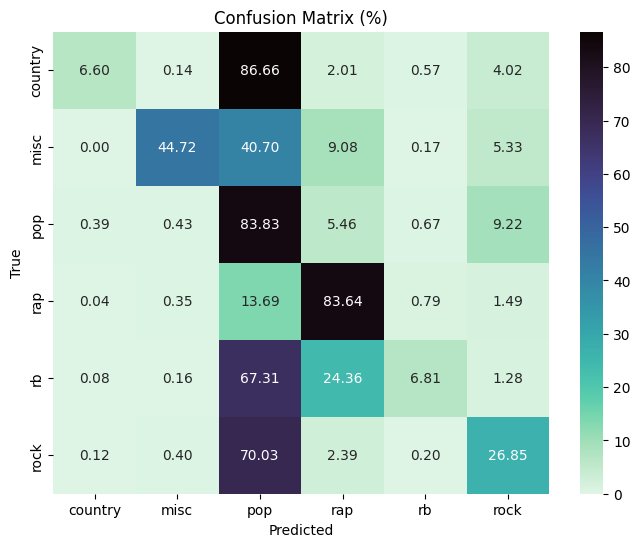

In [11]:
y_pred_decoded_grid = encoder.inverse_transform(y_pred_grid)
y_test_decoded = encoder.inverse_transform(y_test)

plot_confusion_matrix(y_test_decoded, y_pred_decoded_grid)

>With the model from grid search, we obtained a score of **0.6311** on Kaggle. 

There was one model, in section 5. where, using Stratified K Folds, we obtained a better result so we will try to apply a Stratified K Folds with the parameters suggested by the Grid Search, to see if model performance improves.

## 6.4. Improved Stratified K-Folds <a class="anchor" id="section_6_4"></a>

In [13]:
stkf_softmax = LogisticRegression(solver='lbfgs', 
                                  random_state=0, 
                                 # penalty = None, 
                                  max_iter=10000, 
                                  multi_class='multinomial')


#Calling a function defined by us, in utils
avg_accuracy, avg_precision, avg_recall, avg_f1, stkf_final_softmax, vectorizer_stkf = stratified_kfold_crossval(
                                                                                    songs=songs,
                                                                                    data = songs['lyrics_norst_lemm'], 
                                                                                    classifier = stkf_softmax, 
                                                                                    num_folds = 6)



C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\huawei\anaconda3\envs\TextMining\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6


In [14]:
# Display average classification metrics
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Average Accuracy: 0.6591
Average Precision: 0.6492
Average Recall: 0.6591
Average F1 Score: 0.6245


# 7. Final Model <a class="anchor" id="chapter7"></a> 
---

As a final model we pick the Statified K Folds with the parameters obtained in grid search because it was the best results in terms of the f1 score and addresses class imbalance, so it seems like the best model we could hope for. The final preprocessing technique, then, is without the removal of stopwords and with lemmatization.


In [15]:
f1_scores = pd.DataFrame({
    'Model Name': ['OvR Model', 'Softmax Model', 'Best SKF', 'Grid Search', 'Final SKF'],
    'Kaggle F1 Score': [0.6178, 0.6225, 0.6324, 0.6311, 0.6353]
})
f1_scores

,Model Name,Kaggle F1 Score
0,OvR Model,0.6178
1,Softmax Model,0.6225
2,Best SKF,0.6324
3,Grid Search,0.6311
4,Final SKF,0.6353


#### Applying model to the test set

This section serves to apply the final model on the provided test set, where we do not have access to the tag of any lyrics, and submit it to Kaggle, so that we can see how the model performs on unseen data and participate in the class competition.

In [16]:
data_test = pd.read_csv('preproc_test.csv')
data_test.set_index('id', inplace = True)

In [17]:
#The vectorizer used needs to be the same as the one used for training our data

test_vec = vectorizer_stkf.transform(data_test['lyrics_norst_lemm'])

In [18]:
data_test['model'] = stkf_final_softmax.predict(test_vec)
data_test['tag'] = encoder.inverse_transform(data_test['model'])

In [19]:
df = data_test[['tag']].copy()
df['tag'].value_counts()

tag
pop        19623
rap         9592
rock        3328
misc         810
rb           251
country      138
Name: count, dtype: int64

In [20]:
df.to_csv('final_stkf_predictions.csv')